# TMDB Box Office Prediction
![](https://miro.medium.com/max/986/1*ipv_blIqB1SFUO5gmLAhtQ.png)

In a world… where movies made an estimated $41.7 billion in 2018, the film industry is more popular than ever. But what movies make the most money at the box office? How much does a director matter? Or the budget? For some movies, it's "You had me at 'Hello.'" For others, the trailer falls short of expectations and you think "What we have here is a failure to communicate."

In this dataset, there are 7398 movies with a variety of metadata obtained from The Movie Database (TMDB). Movies are labeled with id. Data points include cast, crew, plot keywords, budget, posters, release dates, languages, production companies, and countries.We are predicting the worldwide revenue for 4398 movies in the test file.

Note - Many movies are remade over the years, therefore it may seem like multiple instance of a movie may appear in the data, however they are different and should be considered separate movies. In addition, some movies may share a title, but be entirely unrelated.

E.g. The Karate Kid (id: 5266) was released in 1986, while a clearly (or maybe just subjectively) inferior remake (id: 1987) was released in 2010. Also, while the Frozen (id: 5295) released by Disney in 2013 may be the household name, don't forget about the less-popular Frozen (id: 139) released three years earlier about skiers who are stranded on a chairlift...

# Installing Packages

In [2]:
!pip install seaborn
!pip install plotly
!pip install opendatasets
!pip install xgboost
!pip install wordcloud==1.8.1 --quiet

ERROR: Invalid requirement: '=='


# Import Libraires

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import opendatasets as od
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

# Download and prepare the dataset for training

In [3]:
od.download('https://www.kaggle.com/c/tmdb-box-office-prediction/overview')
od.download('https://www.kaggle.com/kamalchhirang/tmdb-competition-additional-features')

Skipping, found downloaded files in "./tmdb-box-office-prediction" (use force=True to force download)
Skipping, found downloaded files in "./tmdb-competition-additional-features" (use force=True to force download)


In [4]:
outlier='tmdb-box-office-prediction'
outlier1='tmdb-competition-additional-features'
os.listdir(outlier1)

['TestAdditionalFeatures.csv', 'TrainAdditionalFeatures.csv']

In [5]:
train_df=pd.read_csv(outlier+'/train.csv')
test_df=pd.read_csv(outlier+'/test.csv')
submission_df=pd.read_csv(outlier+'/sample_submission.csv')
test_feature_df=pd.read_csv(outlier1+'/TestAdditionalFeatures.csv')
train_feature_df=pd.read_csv(outlier1+'/TrainAdditionalFeatures.csv')

In [6]:
train_df.head(3)

id                              belongs_to_collection    budget  \
0   1  [{'id': 313576, 'name': 'Hot Tub Time Machine ...  14000000   
1   2  [{'id': 107674, 'name': 'The Princess Diaries ...  40000000   
2   3                                                NaN   3300000   

                                              genres  \
0                     [{'id': 35, 'name': 'Comedy'}]   
1  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
2                      [{'id': 18, 'name': 'Drama'}]   

                            homepage    imdb_id original_language  \
0                                NaN  tt2637294                en   
1                                NaN  tt0368933                en   
2  http://sonyclassics.com/whiplash/  tt2582802                en   

                             original_title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   
2                                  Whiplash   

                                            overview  popularity  ...  \
0  When Lou, who has become the "father of the In...    6.575393  ...   
1  Mia Thermopolis is now a college graduate and ...    8.248895  ...   
2  Under the direction of a ruthless instructor, ...   64.299990  ...   

  release_date runtime                          spoken_languages    status  \
0      2/20/15    93.0  [{'iso_639_1': 'en', 'name': 'English'}]  Released   
1       8/6/04   113.0  [{'iso_639_1': 'en', 'name': 'English'}]  Released   
2     10/10/14   105.0  [{'iso_639_1': 'en', 'name': 'English'}]  Released   

                                             tagline  \
0  The Laws of Space and Time are About to be Vio...   
1  It can take a lifetime to find true love; she'...   
2    The road to greatness can take you to the edge.   

                                      title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   
2                                  Whiplash   

                                            Keywords  \
0  [{'id': 4379, 'name': 'time travel'}, {'id': 9...   
1  [{'id': 2505, 'name': 'coronation'}, {'id': 42...   
2  [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...   

                                                cast  \
0  [{'cast_id': 4, 'character': 'Lou', 'credit_id...   
1  [{'cast_id': 1, 'character': 'Mia Thermopolis'...   
2  [{'cast_id': 5, 'character': 'Andrew Neimann',...   

                                                crew   revenue  
0  [{'credit_id': '59ac067c92514107af02c8c8', 'de...  12314651  
1  [{'credit_id': '52fe43fe9251416c7502563d', 'de...  95149435  
2  [{'credit_id': '54d5356ec3a3683ba0000039', 'de...  13092000  

[3 rows x 23 columns]

### Merging existing dataset with additional dataset


In [7]:
# Merging existing dataset with additional dataset
train_set = pd.merge(train_df, train_feature_df, how='left', on='imdb_id')

In [8]:
print(f"There are {train_set.shape[0]} rows and {train_set.shape[1]} columns in our dataset")

There are 3000 rows and 26 columns in our dataset


In [9]:
train_set.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 2999
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

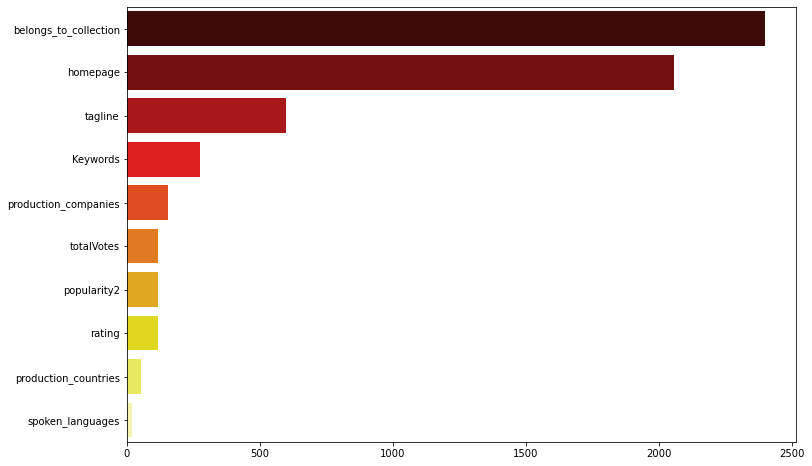

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
missing_values=train_set.isna().sum().sort_values(ascending=False)
sns.barplot(x=missing_values[:10],y=missing_values[:10].index,palette="hot")
plt.show()

Keyword is the most missing value of our dataset

### Splitting Date into Day of Week, Month, Year

In [11]:
train_set['release_day']=pd.to_datetime(train_set.release_date).dt.dayofweek
train_set['release_month']=pd.to_datetime(train_set.release_date).dt.month;
train_set['release_year']=pd.to_datetime(train_set.release_date).dt.year;
train_set['release_date']=pd.to_datetime(train_set.release_date)

### Plot representing Movies that are going to release in future years

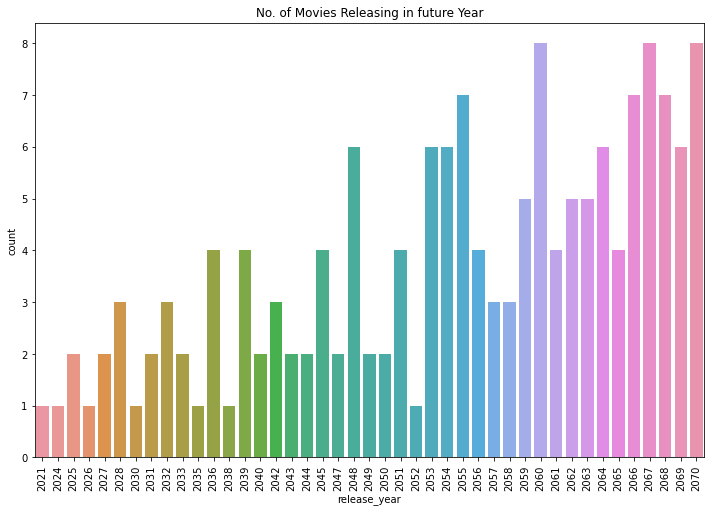

In [12]:
plt.figure(figsize=(12,8))
plt.title('No. of Movies Releasing in future Year')
sns.countplot(x=train_set[train_set.release_year>2020]['release_year']);
plt.xticks(rotation=90);

### Stripplot representing Revenue earned by Movies on specific days of  week 

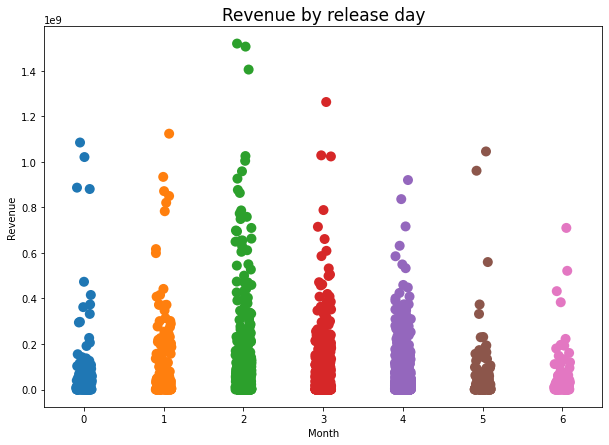

In [13]:
plt.figure(figsize=(10,7))
sns.stripplot(x='release_day', y= 'revenue', data=train_set,s=10)
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.title('Revenue by release day', fontsize=17);

### Barplot representing Revenue earned by Movies on specific Month.

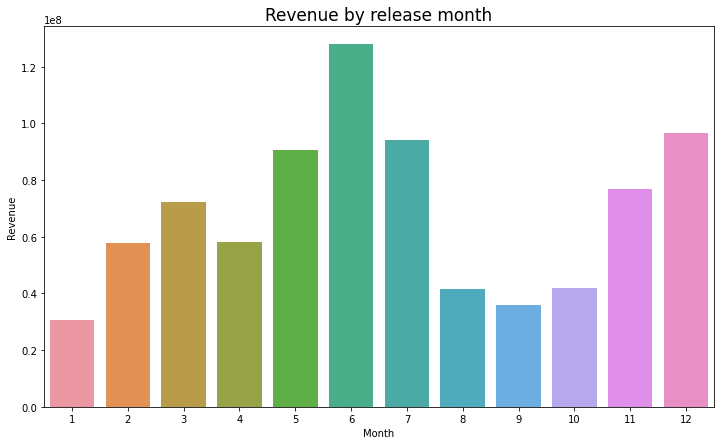

In [14]:
plt.figure(figsize=(12,7))
sns.barplot(x='release_month', y= 'revenue', data=train_set,ci=0)
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.title('Revenue by release month', fontsize=17);


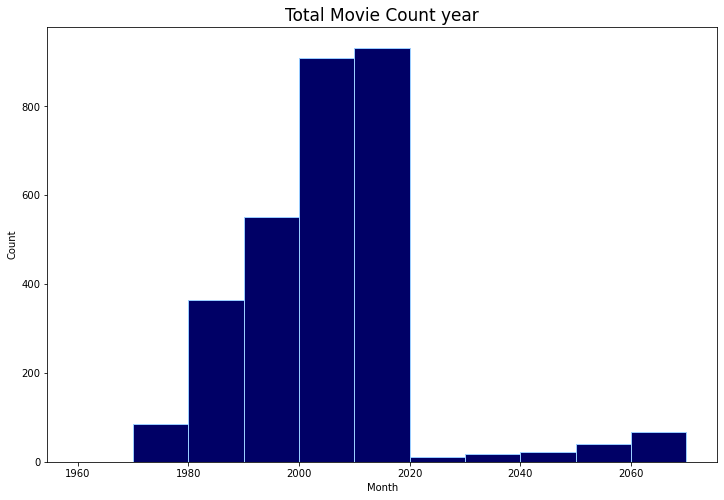

In [15]:
plt.figure(figsize=(12,8))
plt.hist(x='release_year', data=train_set,bins=np.arange(1960,2080,10),edgecolor='#99ccff',color='#000066')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Total Movie Count year', fontsize=17);

### Release Year with respect to total budget

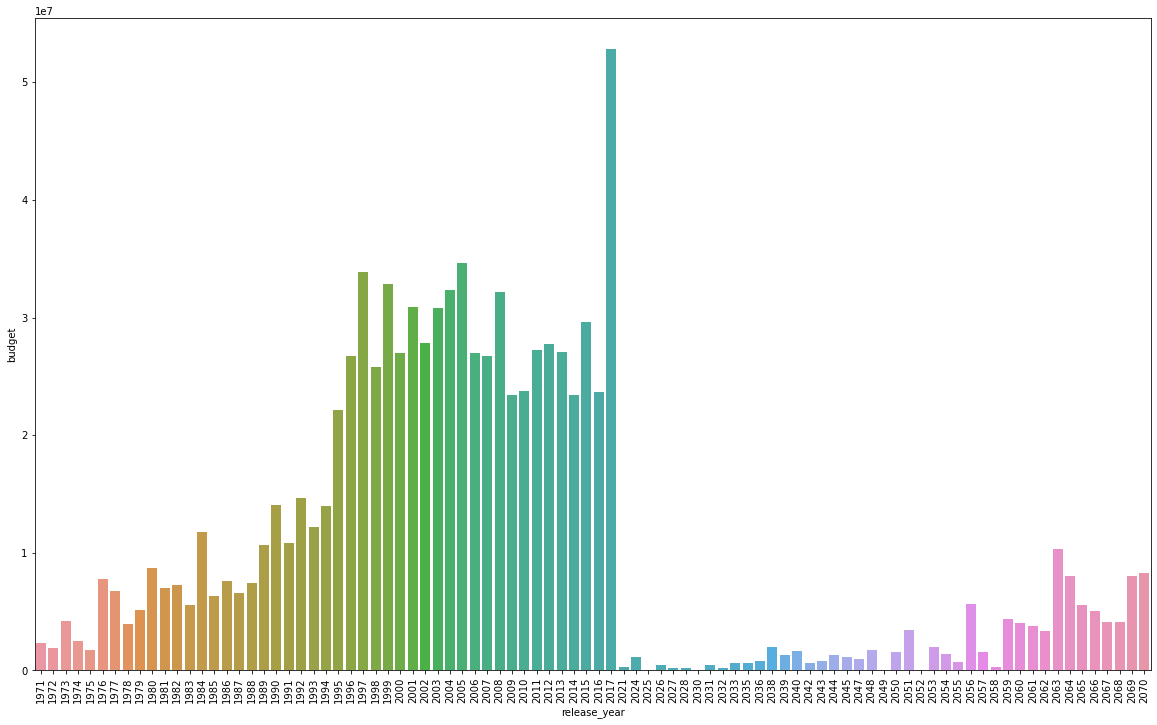

In [16]:
plt.figure(figsize=(20,12))
sns.barplot(x=train_set.release_year,y=train_set['budget'],ci=0)

plt.xticks(rotation=90);

## Cleaning and Preparing Data

In [17]:
train_set['belongs_to_collection'] = train_set['belongs_to_collection'].fillna(0)
train_set['belongs_to_collection'] = train_set['belongs_to_collection'].apply(lambda x: 0 if x==0 else 1)

train_set['homepage'] = train_set['homepage'].fillna(0)
train_set['homepage'] = train_set['homepage'].apply(lambda x: 0 if x==0 else 1)

train_set['poster_path'] = train_set['poster_path'].fillna(0)
train_set['poster_path'] = train_set['poster_path'].apply(lambda x: 0 if x==0 else 1)

train_set['overview'] = train_set['overview'].fillna(0)
train_set['overview'] = train_set['overview'].apply(lambda x: 0 if x==0 else 1)

train_set['tagline'] = train_set['tagline'].fillna(0)
train_set['tagline'] = train_set['tagline'].apply(lambda x: 0 if x==0 else 1)

In [18]:
print(type(train_set.genres[0]))
train_set['genres']=train_set['genres'].fillna('0')  # Replace Nan with String "0" value
train_set['genres'].isna().sum()

<class 'str'>


0

In [19]:
from ast import literal_eval
train_set['new_genres'] = train_set['genres'].apply(literal_eval)
train_set.head().iloc[0]['new_genres']

[{'id': 35, 'name': 'Comedy'}]

In [20]:
type(train_set['new_genres'][0])

list

**Thus we have Succesfully converted String object to List object**

In [21]:
train_set['new_genres']

0                          [{'id': 35, 'name': 'Comedy'}]
1       [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
2                           [{'id': 18, 'name': 'Drama'}]
3       [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...
4       [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...
                              ...                        
2995    [{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...
2996    [{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...
2997    [{'id': 80, 'name': 'Crime'}, {'id': 28, 'name...
2998    [{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...
2999    [{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...
Name: new_genres, Length: 3000, dtype: object

### Collecting Names present in json format to single list

In [22]:
train_set['genre_names'] = train_set['new_genres']\
                        .apply(lambda x: [e['name'] for e in x] if isinstance(x,list) else [])

In [23]:
train_set['genre_names']

0                                 [Comedy]
1         [Comedy, Drama, Family, Romance]
2                                  [Drama]
3                        [Thriller, Drama]
4                       [Action, Thriller]
                       ...                
2995                     [Comedy, Romance]
2996                        [Drama, Music]
2997    [Crime, Action, Mystery, Thriller]
2998                     [Comedy, Romance]
2999           [Thriller, Action, Mystery]
Name: genre_names, Length: 3000, dtype: object

In [24]:
train_set.columns.tolist()

['id',
 'belongs_to_collection',
 'budget',
 'genres',
 'homepage',
 'imdb_id',
 'original_language',
 'original_title',
 'overview',
 'popularity',
 'poster_path',
 'production_companies',
 'production_countries',
 'release_date',
 'runtime',
 'spoken_languages',
 'status',
 'tagline',
 'title',
 'Keywords',
 'cast',
 'crew',
 'revenue',
 'popularity2',
 'rating',
 'totalVotes',
 'release_day',
 'release_month',
 'release_year',
 'new_genres',
 'genre_names']

## MultiLabelBinarizer

* Separating Listed value present in 'genre_name' into separate column , similar to `OneHotEncoder` (which separates Single value of column as header of separate column).  
* But here we are dealing with Listed value present in one column thus we use `MultiLabelBinarizer`


In [25]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
list_of_genres = pd.DataFrame(mlb.fit_transform(train_set['genre_names']),columns=mlb.classes_, index=train_set.index)
train_set = train_set.join(list_of_genres)

There are 163 words in the combination of all Product Name.


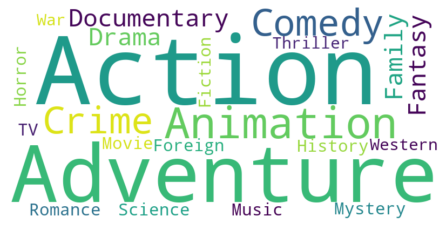

In [26]:
# from wordcloud import WordCloud
text = " ".join(i for i in list_of_genres.astype(str))
print ("There are {} words in the combination of all Genre Name.".format(len(text)))

# Create and generate a word cloud image:
wordcloud = WordCloud(background_color="white", width=800, height=400).generate(text)

plt.axis("off")
plt.rcParams["figure.figsize"] = (15,6)
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

In [27]:
new1=train_set.describe().columns.tolist()

In [28]:
new2=train_set.corr().revenue.tolist()

In [29]:
new_train=pd.DataFrame({'revenue_corr':new1,'val':new2}, index=[x for x in range(len(new2))])
new_train.sort_values(['val'],ascending=False)

revenue_corr       val
9                 revenue  1.000000
12             totalVotes  0.772320
2                  budget  0.752965
10            popularity2  0.629759
5              popularity  0.461460
1   belongs_to_collection  0.339425
17              Adventure  0.328439
3                homepage  0.263179
7                 runtime  0.216380
16                 Action  0.184584
8                 tagline  0.180366
24                Fantasy  0.171040
23                 Family  0.161677
11                 rating  0.149093
31        Science Fiction  0.132367
18              Animation  0.130828
4                overview  0.023361
14          release_month  0.020164
15           release_year  0.012325
6             poster_path  0.008852
33               Thriller  0.006998
0                      id  0.000610
32               TV Movie -0.003283
35                Western -0.013466
29                Mystery -0.014686
20                  Crime -0.022648
34                    War -0.022701
19                 Comedy -0.030717
28                  Music -0.032214
27                 Horror -0.034041
26                History -0.044172
25                Foreign -0.048191
30                Romance -0.049436
21            Documentary -0.078030
13            release_day -0.140494
22                  Drama -0.158280

In [30]:
list_genres=list_of_genres.columns.tolist()
values=train_set.revenue.tolist()

### Representation of different Genre contribution to Revenue via `Piechart`

In [31]:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Pie(labels=list_genres, values=values)])
fig.show()

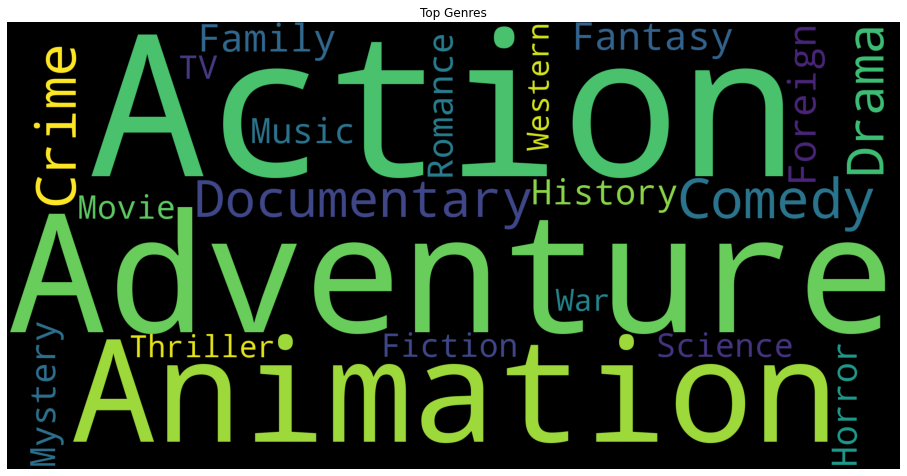

In [32]:
# from wordcloud import WordCloud
plt.figure(figsize=(16,10))
text1 = ' '.join(j for j in list_genres)
wordcloud = WordCloud(max_font_size = None, width = 2000, height = 1000,
                      collocations =False).generate(text)
plt.imshow(wordcloud)
plt.title('Top Genres')
plt.axis('off')
plt.show()
# 1.8.1

In [33]:
numeric_col=['belongs_to_collection', 'budget', 'homepage','overview',
       'popularity', 'poster_path','runtime','tagline','Action','Adventure','Animation',
        'Comedy','Crime','Documentary','Drama','Family','Fantasy','Foreign','History','Horror',
        'Music','Mystery','Romance','Science Fiction','Thriller','War','Western',
       'popularity2', 'rating', 'totalVotes']
catagorical_col=['original_language','status']

### Imputing Missing Numeric Data 

In [34]:
from sklearn.impute import SimpleImputer
impute=SimpleImputer(strategy='mean').fit(train_set[numeric_col])
train_set[numeric_col]=impute.transform(train_set[numeric_col])


### Scaling Numeric Features

In [35]:
from sklearn.preprocessing import MinMaxScaler
scalar=MinMaxScaler().fit(train_set[numeric_col])
train_set[numeric_col]=scalar.transform(train_set[numeric_col])

### Encoding Categorical Data

In [36]:
from sklearn.preprocessing import OneHotEncoder
encode=OneHotEncoder(sparse=False,handle_unknown='ignore').fit(train_set[catagorical_col])
catagorical_col_names=encode.get_feature_names(catagorical_col).tolist()
train_set[catagorical_col_names]=encode.transform(train_set[catagorical_col])


* **`SimpleImputer` and `MinMaxScaler` for Numeric columns**
* **`OneHotEncoder` for Categorical columns**

# Computing Insights using different Plots

In [37]:
fig = px.scatter(train_set, x="budget", y="revenue", color="original_language", title = 'Budget vs Revenue in different languages'
                ,height=700)
fig.show()

### Relation of Budget vs Popularity of movie

In [38]:
px.scatter(data_frame = train_set, y='budget',x='popularity',color='popularity2', title = 'Budget vs Popularity')

### VotingCount  is propotional to Popularity of Movie & its Revenue Collection

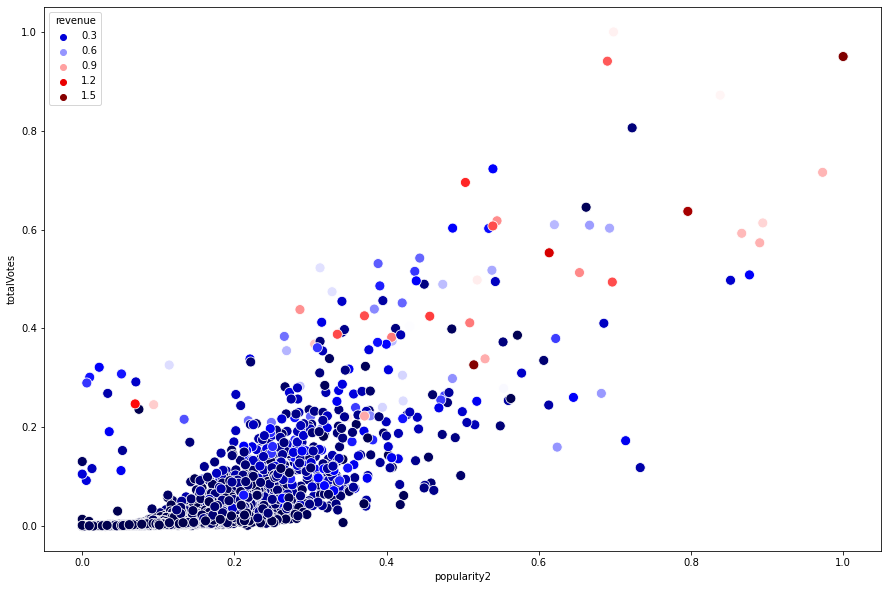

In [39]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=train_set, x="popularity2", y="totalVotes", hue='revenue',palette="seismic",s=100);


### Scatterplot for Revenue vs TotalVotes along with Budget of Movie

In [40]:
px.scatter(train_set, x="revenue", y="totalVotes", color='budget',title = 'Revenue Earned vs Votes with Budget of Movie'
                ,height=700)

### Identifying Input and Target Columns


In [41]:
train_col=numeric_col+catagorical_col_names
target_col='revenue'
final_train=train_set[train_col]
final_target=train_set[target_col]


### Correlation between Numeric columns

In [42]:
corr = final_train[numeric_col].corr()
corr.style.background_gradient(cmap='inferno')


# Train Test Split 

In [43]:
from sklearn.model_selection import train_test_split
train, val, train_targets, val_targets = train_test_split(final_train, final_target, test_size=0.1,random_state=42)

# 2 Different type of machine learning models used are :
* **RandomForestRegressor**
* **XGBRegressor**

### 1) RandomForestRegressor

In [44]:
from sklearn.ensemble import RandomForestRegressor
model=RandomForestRegressor(n_jobs=-1,random_state=42,n_estimators=10).fit(train,train_targets)

In [45]:
from sklearn.metrics import accuracy_score,mean_squared_error
model.score(train,train_targets)

0.9571851583688813

In [46]:
model.score(val,val_targets)

0.7928618134147484

**RandomForestRegressor - Hyperparameter 1**

In [47]:
model1 = RandomForestRegressor(random_state=42, 
                                  max_features='auto', 
                                  n_estimators= 50, 
                                  min_samples_leaf=2).fit(train,train_targets)

In [48]:
model1.score(train,train_targets)

0.9444508985730615

In [49]:
model1.score(val,val_targets)

0.8135689991213654

In [50]:
def test_params_new(**nparams):
    model = RandomForestRegressor(random_state=42, n_jobs=-1, **nparams).fit(train,train_targets)
    ip_score= model.score(train,train_targets)*100
    val_score=model.score(val,val_targets)*100
    return ip_score,val_score

def test_param_and_plot_new(nparam_name, nparam_values):
    train_acc, val_acc = [], [] 
    for value in nparam_values:
        nparams = {nparam_name: value}
        train_score, val_score = test_params_new(**nparams)
        train_acc.append(train_score)
        val_acc.append(val_score)
    plt.figure(figsize=(10,6))
    plt.title('Accuracy curve: ' + nparam_name)
    plt.plot(nparam_values, train_acc, 'b-o')
    plt.plot(nparam_values, val_acc, 'r-o')
    plt.xlabel(nparam_name)
    plt.ylabel('Accuracy')
    plt.legend(['Training', 'Validation'])


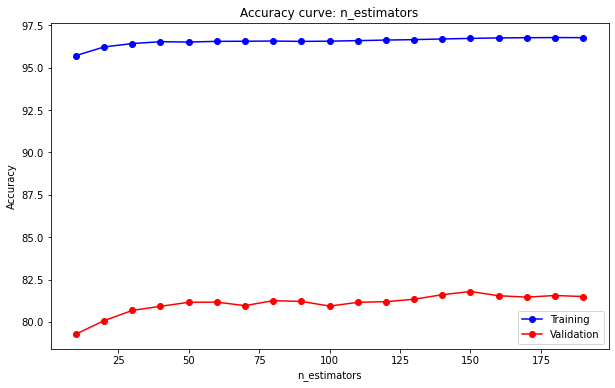

In [51]:
test_param_and_plot_new('n_estimators',list(range(10,200,10))) #61

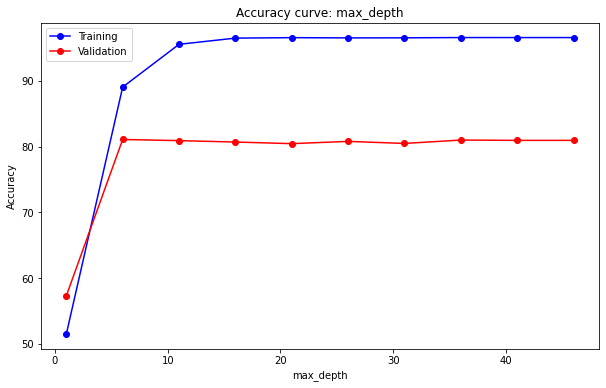

In [52]:
test_param_and_plot_new('max_depth', list(range(1,50,5)))   #25


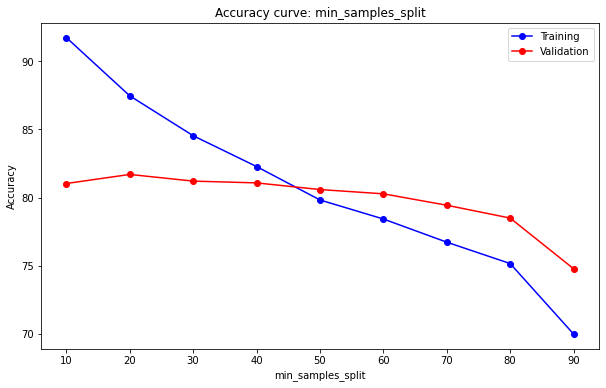

In [53]:
test_param_and_plot_new('min_samples_split', list(range(10,100,10)))  #18

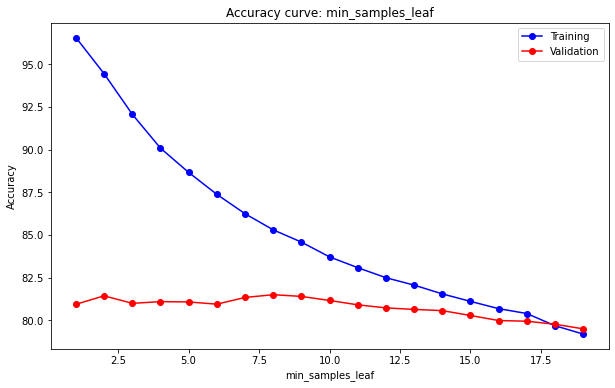

In [54]:
test_param_and_plot_new('min_samples_leaf', list(range(1,20,1))) #8


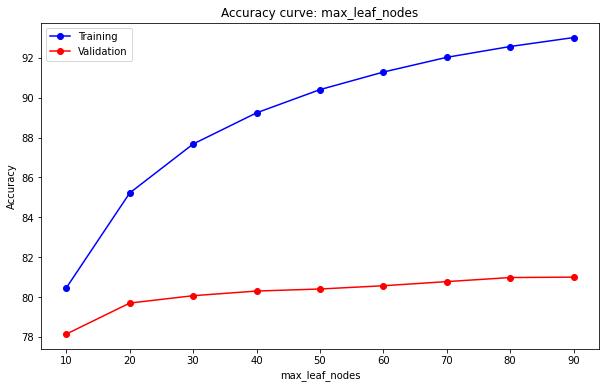

In [55]:
test_param_and_plot_new('max_leaf_nodes', list(range(10,100,10))) #90


#### RandomForestRegressor - Hyperparameter 2

In [56]:
%%time
model=RandomForestRegressor(n_jobs=-1,
                            random_state=42,
                            max_leaf_nodes=165,
                            min_samples_leaf=1,
                            min_samples_split=20,
                            min_impurity_decrease=1e10,
                            max_depth=50,
                            n_estimators=30000
                           ).fit(train,train_targets)

CPU times: user 8min, sys: 3.94 s, total: 8min 4s
Wall time: 4min 52s


In [57]:
model.score(train,train_targets)

0.8760585907437123

In [58]:
c=model.score(val,val_targets)

In [59]:
print("Accuracy: ",c)

Accuracy:  0.8255975157691616


### We Got an Accuracy of 83 % on Validation set using RandomForestRegressor


In [60]:
importance_df = pd.DataFrame({
    'feature': train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [61]:
pd.DataFrame(importance_df).head(10)

feature  importance
29             totalVotes    0.564352
1                  budget    0.324024
6                 runtime    0.020287
27            popularity2    0.015321
9               Adventure    0.014696
4              popularity    0.014500
28                 rating    0.010836
0   belongs_to_collection    0.008651
10              Animation    0.005269
65   original_language_zh    0.002458

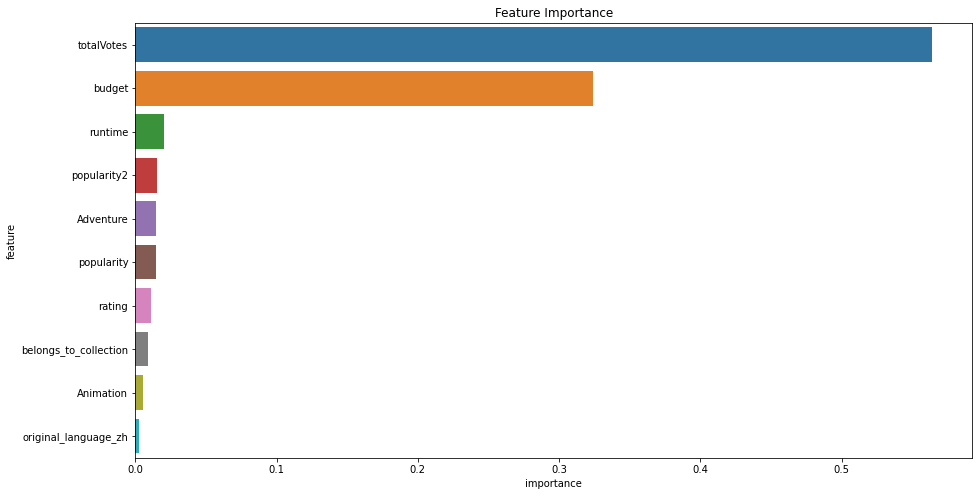

In [62]:
plt.figure(figsize=(15,8))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

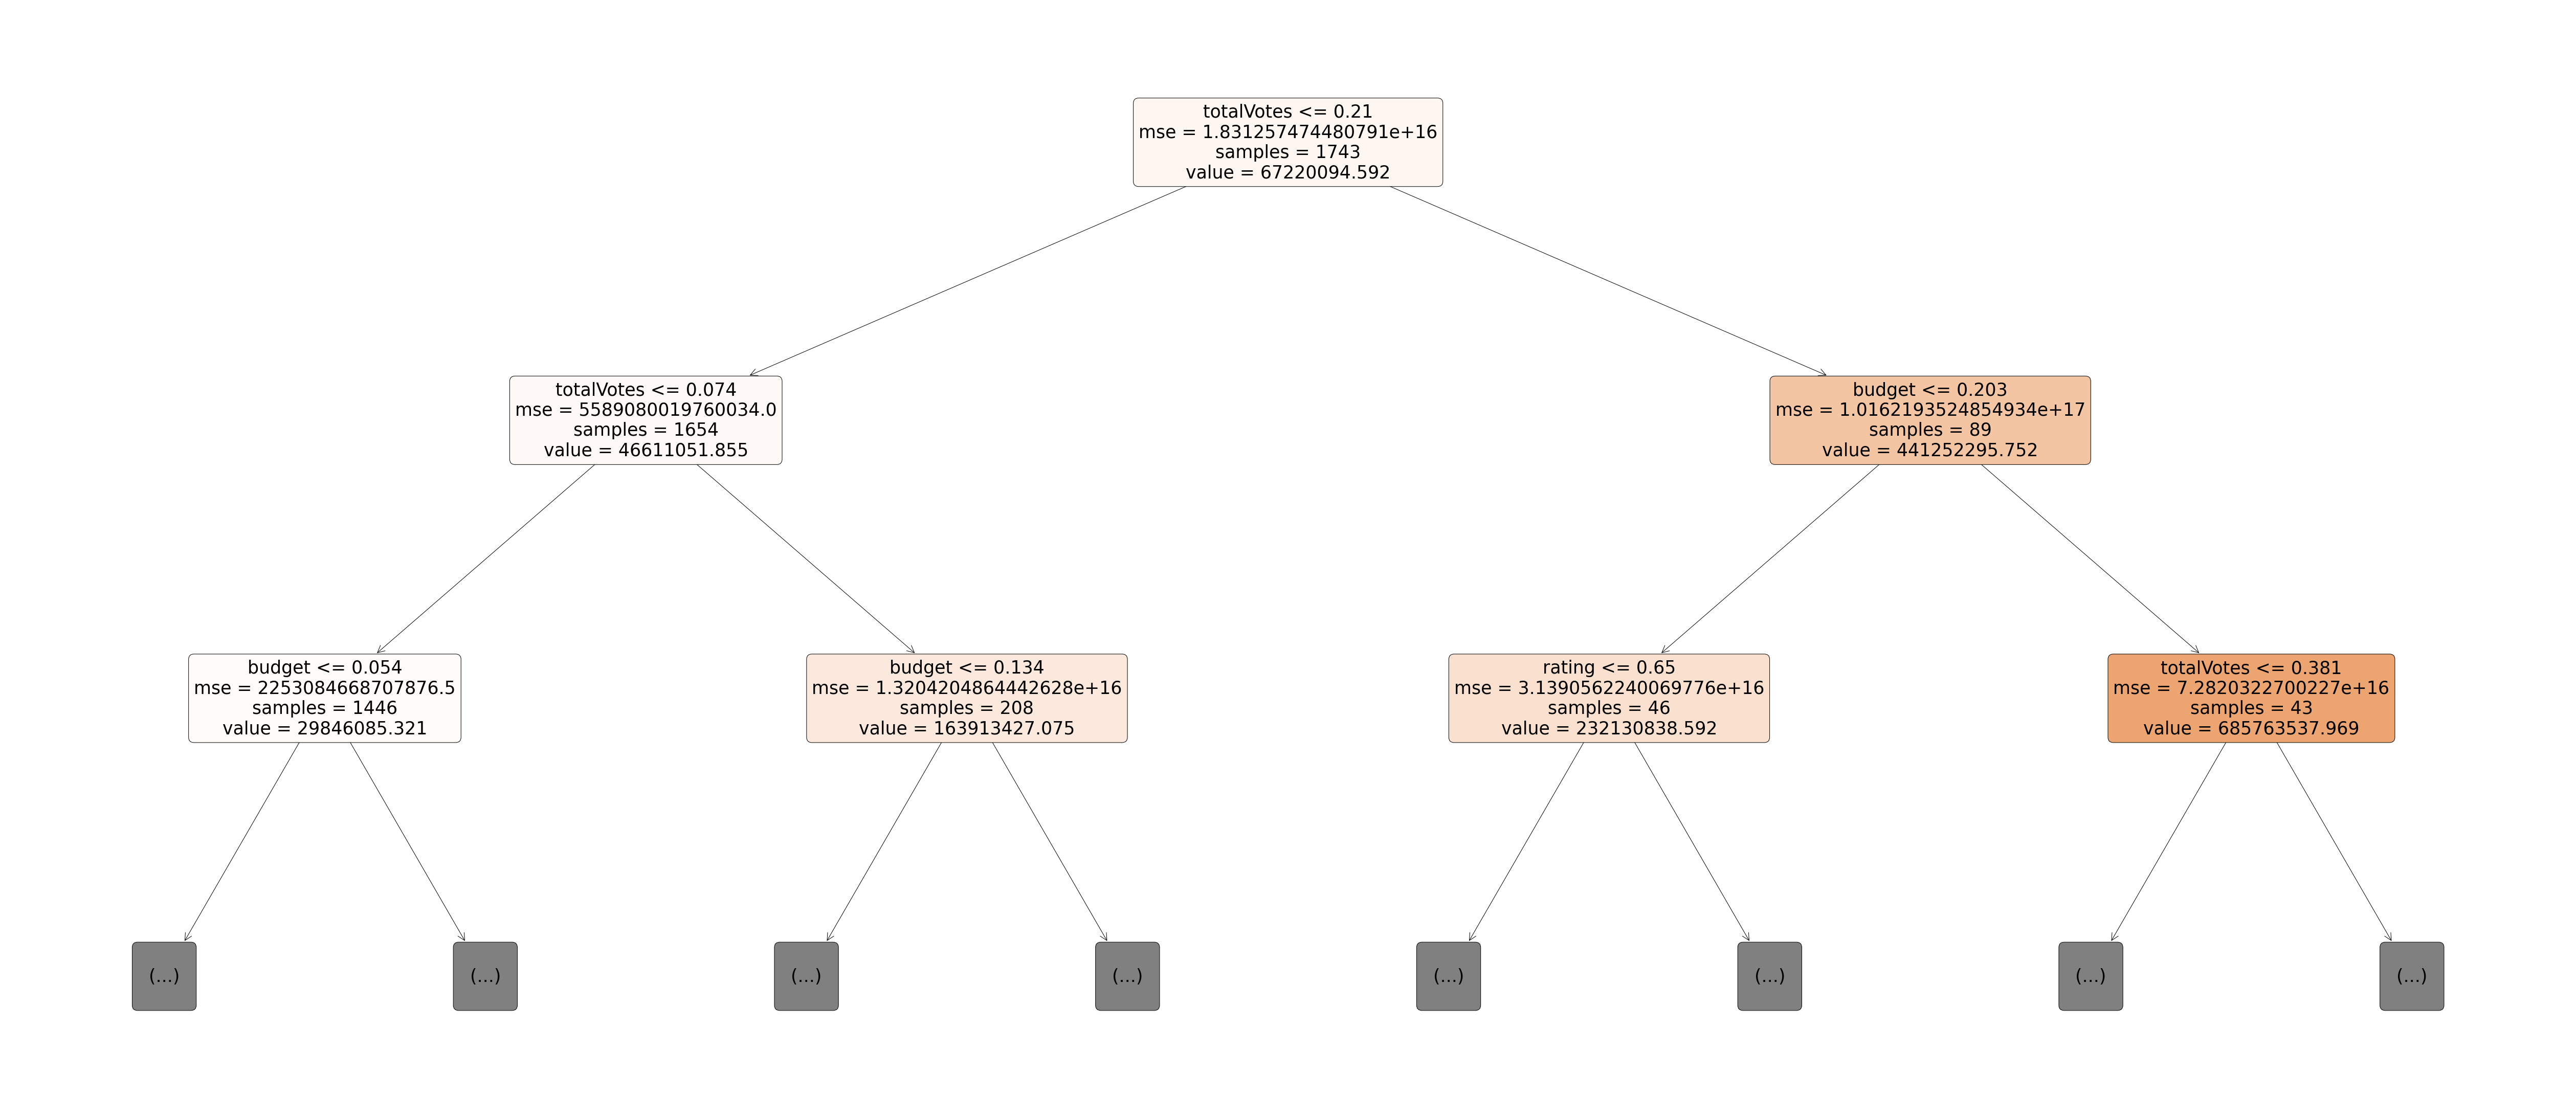

In [63]:
from sklearn.tree import plot_tree, export_text
plt.figure(figsize=(90,40))
plot_tree(model.estimators_[20000], max_depth=2, feature_names=train.columns, filled=True, rounded=True);

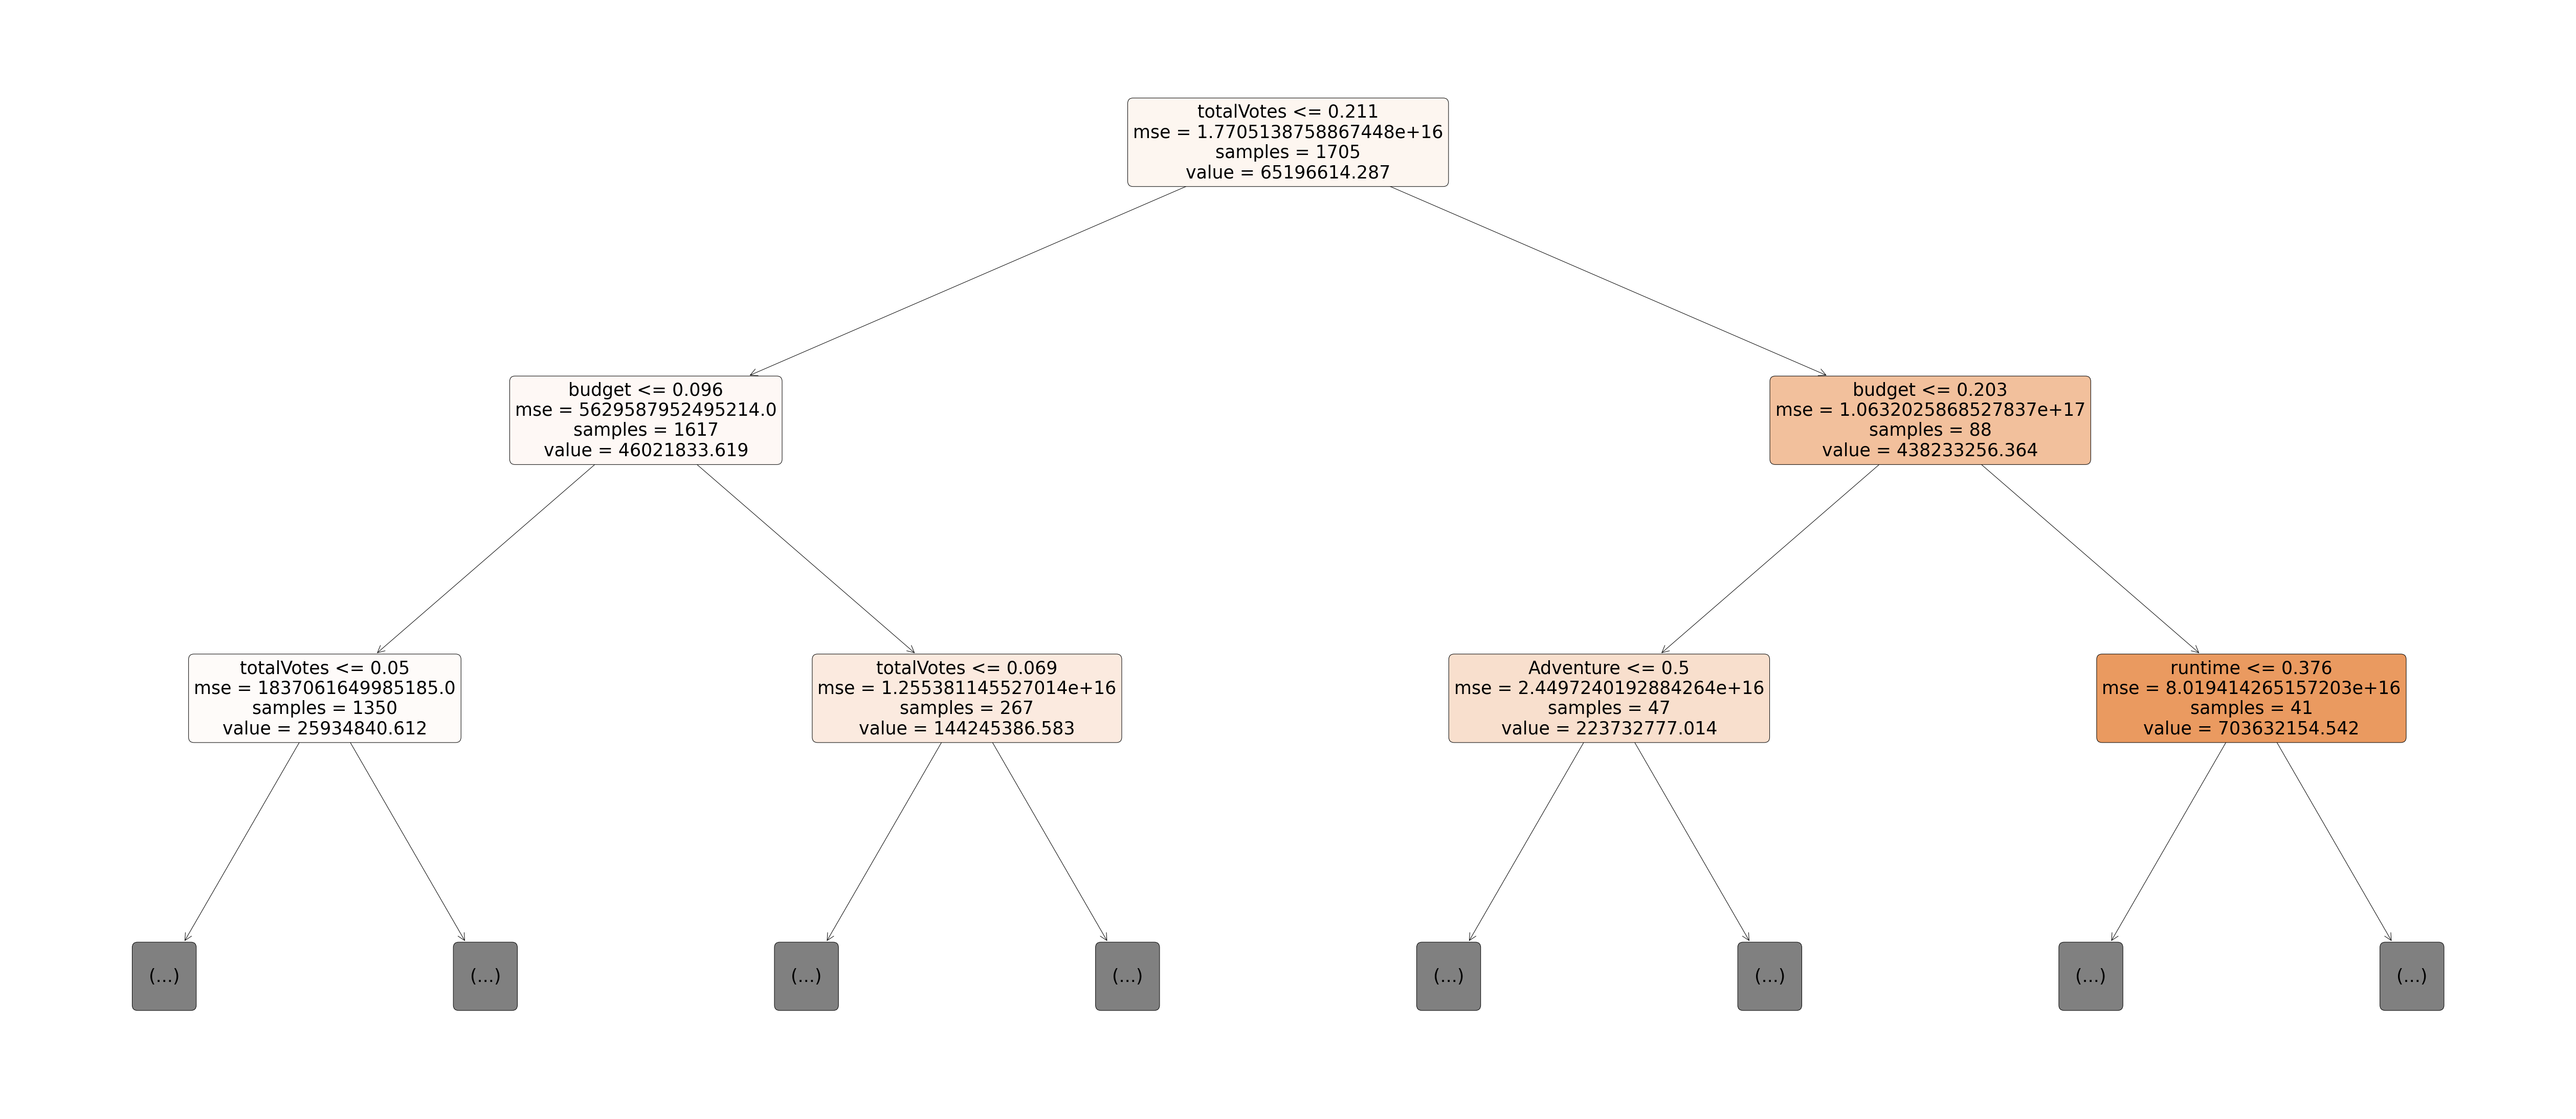

In [64]:
from sklearn.tree import plot_tree, export_text
plt.figure(figsize=(90,40))
plot_tree(model.estimators_[2], max_depth=2, feature_names=train.columns, filled=True, rounded=True);

### 2) XGBRegressor:

##### XGBRegressor - Hyperparameter 1

In [65]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor( eta = 0.009,n_jobs=-1,                                  
                             max_depth = 3,
                                  min_child_weight = 3,
                                  subsample = 0.8,
                                  gamma = 1.45,
                                  colsample_bytree = 0.7,random_state=42,
                                  n_estimators = 3000).fit(train,train_targets)

In [66]:
xgb_model.score(train,train_targets)

0.9342621021909528

In [67]:
xgb_model.score(val,val_targets)

0.8350565647456839

##### XGBRegressor - Hyperparameter 2

In [74]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor( eta = 0.09,n_jobs=-1,                                  
                                  max_depth = 2,
                                  min_child_weight = 14, 
                                  subsample = 0.80008,
                                  gamma = 2,
                                  colsample_bytree = 0.7,
                                  random_state=42,
                                  n_estimators = 283,
                                  verbosity=1,
                                  colsample_bynode =0.8,
                                  colsample_bylevel =0.64,
                                  scale_pos_weight =1.0
                            ).fit(train,train_targets);

In [75]:
xgb_model.score(train,train_targets)

0.855262849225932

In [76]:
xgb_model.score(val,val_targets)

0.8478288785837169

### We Got an Accuracy of 85 % on Validation set using XGBRegressor

In [71]:
importance_df = pd.DataFrame({
    'feature': train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

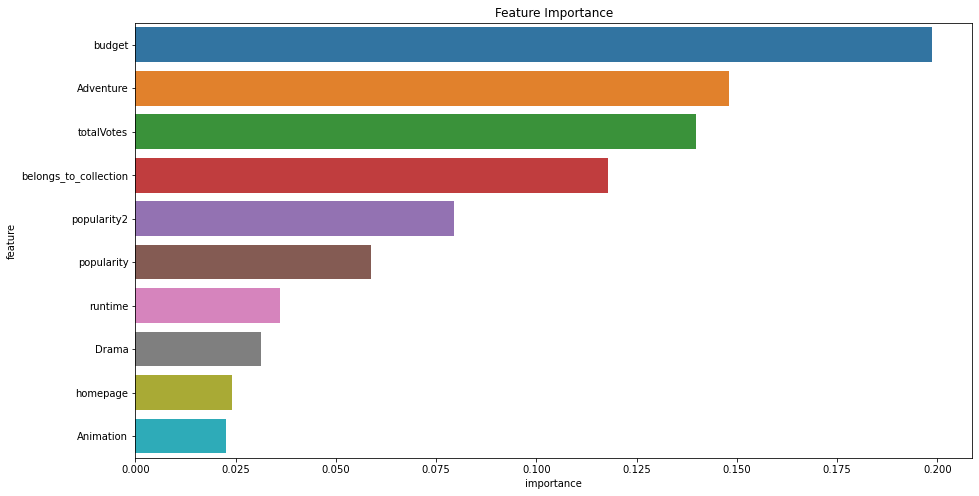

In [72]:
plt.figure(figsize=(15,8))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');